In [69]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from tqdm.auto import tqdm
import itertools
import matplotlib as mpl
import scipy
from scipy.integrate import cumtrapz
import seaborn as sns
import os
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import jax.numpy as jnp
import jax.random as random
import arviz as az

warnings.simplefilter(action='ignore', category=UserWarning)

In [71]:
save_folder=os.path.join(
    os.environ['HOME'],
    'Documents',
    'rpgf',
    'round1_results'
)
os.makedirs(save_folder, exist_ok=True)

In [72]:
df_nofilter = pd.read_csv(os.path.join(os.environ['HOME'], 'code/cel/PRIVATE/rpgf_round1_results/votes_detailed_anon.csv'))
df_nofilter.head()

,voterId,project,amount,projectId,category,projectHash,project_alphabet_pos
0,10,Asia SPWG,1,ID000,Education & Outreach,0xf9f22dc2367a0a06b984f9dd6289f3b9e5b1e91c1da1...,1
1,10,Banyan Storage,2,ID003,Protocol R&D,0xbad5b1ef0e513116a9f4da037fa3b5c9b8e35e744d9d...,2
2,10,B<>rder/ess Developers Programme,1,ID002,Education & Outreach,0x8168c0368b1d4e32fec90360b0ae151530e134ee715b...,2
3,10,Beryx,3,ID004,Infrastructure & Dependencies,0xf9b123ffd4b691b96b8962a81bcbb687deccd2442b3e...,2
4,10,Boost,1,ID006,Tooling & Utilities,0x0c8d608b5440a069fd453703298ecc126c4f01cf520d...,2


In [116]:
def create_votes_raw_heatmap(df, figsize=(8,5), save_fp=None):
    data_mat = df.pivot_table(index='voterId', columns='projectId', values='amount')

    original_cmap = sns.color_palette("coolwarm", as_cmap=True)
    colors = original_cmap(np.linspace(0, 1, 256))
    midpoint = np.abs(colors[:, 0]).argmin()  # Find the approximate midpoint of the colormap
    colors[midpoint] = np.array([0, 0, 0, 1])  # Set the midpoint color to black
    custom_cmap = ListedColormap(colors)

    plt.figure(figsize=figsize)

    sns.heatmap(data_mat, cmap=custom_cmap, cbar_kws={'label': 'Votes'})
    plt.tight_layout()
    if save_fp is not None:
        plt.savefig(save_fp)

def votes2projectcdf(figsize=(6, 4), save_fp=None):
    gb = df_nofilter.groupby('projectId')
    project2numvotes = {}
    project2votes = {}
    for k, v, in gb:
        vv = v['amount'].values
        project2votes[k] = vv
        project2numvotes[k] = len(vv)
    num_total_projects = len(gb)

    votes_list = np.asarray(list(project2numvotes.values()))
    # votes_sorted  = np.sort(votes_list)

    fig, axx = plt.subplots(nrows=1, ncols=1, figsize=figsize)

    # ax = axx[0]
    # ax.hist(votes_list, density=True, cumulative=True, bins=100)
    # # ax.axvline(5, color='k')
    # ax.set_title('CDF of #Votes/project')
    # ax.set_xlabel('#Votes/project')
    # ax.set_ylabel('Cumulative probability')

    # plot the % of projects that meet quorum based on threshold
    quorum_vec = np.arange(1, 10)
    pct_pass_vec = []
    for q in quorum_vec:
        num_projects_pass = 0
        for k,v in project2numvotes.items():
            votes_vec = project2votes[k]
            num_votes_raw = len(votes_vec[votes_vec >= 0])
            num_votes_strictly_positive = len(votes_vec[votes_vec > 0])  # not hte criteria we use
            nv = num_votes_raw
            if nv >= q:
                num_projects_pass += 1
        pct_pass = num_projects_pass/num_total_projects * 100
        pct_pass_vec.append(pct_pass)
        # pct_pass = len(votes_list[votes_list >= q])/len(votes_list) * 100
        # pct_pass_vec.append(pct_pass)
    # ax = axx[1]
    ax = axx
    # ax.stem(quorum_vec, pct_pass_vec)

    (markerline, stemlines, baseline) = ax.stem(quorum_vec, pct_pass_vec, linefmt='gray', markerfmt='o', basefmt="k-")
    plt.setp(markerline, 'markerfacecolor', 'teal')  # Change marker face color
    plt.setp(stemlines, 'color', 'teal', 'linewidth', 1.5)  # Change stem line color and increase line width

    # ax.axvline(5, color='r', linestyle='--')
    # ax.axvline(5, color='r', linestyle='--', label='FIL-RetroPGF-1 Quorum Configuration')
    # ax.legend()
    plt.title('Pct. of Projects Eligible for Distribution \n based on Qorum Threshold')
    plt.xlabel('Quorum')
    plt.ylabel('%')
    plt.tight_layout()
    if save_fp is not None:
        plt.savefig(save_fp)
    
def badgeholder_patterns(df, figsize=(8, 5), save_fp=None):
    ## visualize heatmap of array of votes, ordered in some way
    # each row is a badgeholder
    # each column is their vote.  ragged array but we can pad with something
    gb = df.groupby('voterId')
    voter2votes = {}
    max_len = 0
    for k, v in gb:
        vv = v['amount'].values
        voter2votes[k] = vv
        max_len = max(max_len, len(vv))

    num_voters = len(gb)
    filled_array = np.zeros((num_voters, max_len))
    # now create a non-ragged array
    for i, (k, v) in enumerate(voter2votes.items()):
        filled_array[i, :len(v)] = v
        filled_array[i, len(v):] = np.nan

    # sort by # of nans
    nan_counts = np.sum(np.isnan(filled_array), axis=1)
    sorted_indices = np.argsort(nan_counts)
    filled_array = filled_array[sorted_indices]
    
    plt.figure(figsize=figsize)
    sns.heatmap(filled_array)
    plt.ylabel('Badgeholder')
    plt.xlabel('# of Votes')
    plt.title('Badgeholder Voting Patterns')

    if save_fp is not None:
        plt.savefig(save_fp)

def badgeholder_patterns2(df, figsize=(8, 5), save_fp=None):
    ## visualize heatmap of array of votes, ordered in some way
    # each row is a badgeholder
    # each column is their vote.  ragged array but we can pad with something
    gb = df.groupby('voterId')
    voter2votes = {}
    max_len = 0
    for k, v in gb:
        vv = v['amount'].values
        voter2votes[k] = vv
        max_len = max(max_len, len(vv))

    num_voters = len(gb)
    filled_array = np.zeros((num_voters, max_len))
    # now create a non-ragged array
    for i, (k, v) in enumerate(voter2votes.items()):
        filled_array[i, :len(v)] = v
        filled_array[i, len(v):] = np.nan

    # sort by # of nans
    nan_counts = np.sum(np.isnan(filled_array), axis=1)
    sorted_indices = np.argsort(nan_counts)
    filled_array = filled_array[sorted_indices]

    # order the array more nicely
    filled_array1 = np.where(np.isnan(filled_array), -100, filled_array)
    sorted_filled_array = np.sort(filled_array1, axis=1)[:,::-1]
    sorted_filled_array[sorted_filled_array == -100] = np.nan

    # Creating a custom colormap
    original_cmap = sns.color_palette("coolwarm", as_cmap=True)
    colors = original_cmap(np.linspace(0, 1, 256))
    midpoint = np.abs(colors[:, 0]).argmin()  # Find the approximate midpoint of the colormap
    colors[midpoint] = np.array([0, 0, 0, 1])  # Set the midpoint color to black
    custom_cmap = ListedColormap(colors)

    plt.figure(figsize=figsize)
    sns.heatmap(sorted_filled_array,
                annot=True, 
                annot_kws={"size": 6},
                cmap=custom_cmap, 
                linewidths=.5,  
                cbar_kws={'label': 'Badgeholder Votes'}) 
    plt.ylabel('Badgeholder', fontsize=12)
    plt.xlabel('Vote Number', fontsize=12)
    plt.title('Badgeholder Voting Patterns', fontsize=14, fontweight='bold')
    plt.tight_layout()

    if save_fp is not None:
        plt.savefig(save_fp)

def project_patterns(df, figsize=(8, 5), save_fp=None):
    ## visualize heatmap of array of votes, ordered in some way
    # each row is a badgeholder
    # each column is their vote.  ragged array but we can pad with something
    gb = df.groupby('projectId')
    voter2votes = {}
    max_len = 0
    for k, v in gb:
        vv = v['amount'].values
        voter2votes[k] = vv
        max_len = max(max_len, len(vv))

    num_voters = len(gb)
    filled_array = np.zeros((num_voters, max_len))
    # now create a non-ragged array
    for i, (k, v) in enumerate(voter2votes.items()):
        filled_array[i, :len(v)] = v
        filled_array[i, len(v):] = np.nan

    # sort by # of nans
    nan_counts = np.sum(np.isnan(filled_array), axis=1)
    sorted_indices = np.argsort(nan_counts)
    filled_array = filled_array[sorted_indices]

    # order the array more nicely
    filled_array1 = np.where(np.isnan(filled_array), -100, filled_array)
    sorted_filled_array = np.sort(filled_array1, axis=1)[:,::-1]
    sorted_filled_array[sorted_filled_array == -100] = np.nan

    # Creating a custom colormap
    original_cmap = sns.color_palette("coolwarm", as_cmap=True)
    colors = original_cmap(np.linspace(0, 1, 256))
    midpoint = np.abs(colors[:, 0]).argmin()  # Find the approximate midpoint of the colormap
    colors[midpoint] = np.array([0, 0, 0, 1])  # Set the midpoint color to black
    custom_cmap = ListedColormap(colors)

    plt.figure(figsize=figsize)
    sns.heatmap(sorted_filled_array,
                annot=True, 
                annot_kws={"size": 6},
                cmap=custom_cmap, 
                linewidths=.5,  
                cbar_kws={'label': 'Badgeholder Votes'}) 
    plt.xlabel('Votes', fontsize=12)
    plt.ylabel('Project', fontsize=12)
    plt.title('Project Voting Patterns', fontsize=14, fontweight='bold')
    plt.tight_layout()

    if save_fp is not None:
        plt.savefig(save_fp)

def project_patterns_withname(df, figsize=(8, 5), save_fp=None):
    ## visualize heatmap of array of votes, ordered in some way
    # each row is a badgeholder
    # each column is their vote.  ragged array but we can pad with something
    gb = df.groupby('project')
    project2votes = {}
    max_len = 0
    for k, v in gb:
        vv = v['amount'].values
        project2votes[k] = vv
        max_len = max(max_len, len(vv))

    num_voters = len(gb)
    filled_array = np.zeros((num_voters, max_len))
    # now create a non-ragged array
    project_list = []
    for i, (k, v) in enumerate(project2votes.items()):
        filled_array[i, :len(v)] = v
        filled_array[i, len(v):] = np.nan

        project_str = k[0:10] + '...' if len(k) > 10 else k
        project_list.append(project_str)

    # # sort by # of nans
    nan_counts = np.sum(np.isnan(filled_array), axis=1)
    sorted_indices = np.argsort(nan_counts)
    filled_array = filled_array[sorted_indices]
    project_list = [project_list[i] for i in sorted_indices]

    # order the array more nicely
    filled_array1 = np.where(np.isnan(filled_array), -100, filled_array)
    # sorted_filled_array = np.sort(filled_array1, axis=1)[:,::-1]
    # sorted_filled_array[sorted_filled_array == -100] = np.nan
    ix_resort = np.argsort(filled_array1, axis=1)[:,::-1]
    sorted_filled_array = np.zeros_like(filled_array1)
    for i in range(len(ix_resort)):
        sorted_filled_array[i] = filled_array1[i, ix_resort[i]]
    sorted_filled_array[sorted_filled_array == -100] = np.nan

    # Creating a custom colormap
    original_cmap = sns.color_palette("coolwarm", as_cmap=True)
    colors = original_cmap(np.linspace(0, 1, 256))
    midpoint = np.abs(colors[:, 0]).argmin()  # Find the approximate midpoint of the colormap
    colors[midpoint] = np.array([0, 0, 0, 1])  # Set the midpoint color to black
    custom_cmap = ListedColormap(colors)

    plt.figure(figsize=figsize)
    sns.heatmap(sorted_filled_array,
                annot=True, 
                annot_kws={"size": 6},
                cmap=custom_cmap, 
                linewidths=.5,  
                cbar_kws={'label': 'Badgeholder Votes'},
                yticklabels=project_list,
                xticklabels=range(1, max_len+1))
    plt.xlabel('Ballot', fontsize=12)
    plt.ylabel('Project', fontsize=12)
    plt.title('Project Voting Patterns', fontsize=14, fontweight='bold')
    plt.tight_layout()

    if save_fp is not None:
        plt.savefig(save_fp)

def votes_distribution(df, figsize=(8, 5), save_fp=None):
    gb = df.groupby('projectId')
    project2numvotes = {}
    for k, v, in gb:
        project2numvotes[k] = len(v)

    votes_list = np.asarray(list(project2numvotes.values()))    

    # distribution of votes per project
    fig, axx = plt.subplots(nrows=1, ncols=2, figsize=figsize)

    bins = np.arange(0,votes_list.max()+1.5)-0.5

    ax = axx[0]
    ax.hist(votes_list,bins, density=True, color='skyblue', edgecolor='black')
    # ax.axvline(5, color='red', linestyle='dashed', linewidth=2)  # Adds a vertical line at x=5
    # ax.text(5.25, 0.95 * max(n), 'Quorum Cutoff', rotation=0, verticalalignment='center', fontsize=12, color='red', bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))
    ax.set_title('Density Histogram', fontsize=14)  # Adding a title
    ax.set_xlabel('Ballots cast per Project', fontsize=12)  # X-axis label
    ax.set_ylabel('Probability', fontsize=12)  # Y-axis label

    ax = axx[1]
    n, bins, patches = ax.hist(votes_list,bins, density=True, cumulative=True, color='lightgreen', edgecolor='black')
    ax.axvline(5, color='red', linestyle='dashed', linewidth=2)  # Adds a vertical line at x=5
    ax.text(5.25, 0.95 * max(n), 'Quorum Cutoff', rotation=0, verticalalignment='center', fontsize=12, color='red', bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))
    ax.set_title('Cumulative Distribution Function', fontsize=14)  # Adding a title
    ax.set_xlabel('Ballots cast per Project', fontsize=12)  # X-axis label
    ax.set_ylabel('Cumulative Probability', fontsize=12)  # Y-axis label
    plt.tight_layout()
    plt.show()

    if save_fp is not None:
        plt.savefig(save_fp)

def votes_per_project_histogram(df, figsize=(8, 5), save_fp=None):
    plt.figure(figsize=figsize)
    vc = df['amount'].value_counts()
    ix = vc.index
    iy = vc.values
    (markerline, stemlines, baseline) = plt.stem(ix, iy, linefmt='gray', markerfmt='o', basefmt="k-")
    plt.setp(markerline, 'markerfacecolor', 'teal')  # Change marker face color
    plt.setp(stemlines, 'color', 'teal', 'linewidth', 1.5)  # Change stem line color and increase line width
    plt.xlabel('Number of votes allocated to a given project', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)  # Adding a y-label for clarity
    plt.title('Badgeholder vote allocations', fontsize=14, fontweight='bold')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='grey', alpha=0.5)
    plt.tight_layout()
    if save_fp is not None:
        plt.savefig(save_fp)
        

def get_votes_by_badgeholder(df):
    gb = df.groupby('voterId')
    voter2votes = {}
    for k, v in gb:
        vv = v['amount'].values
        voter2votes[k] = vv

    return voter2votes

def filter_badgeholders_by_numvotes(df, min_votes=None, max_votes=None):
    gb = df.groupby('voterId')
    df_list = []
    for k, v in gb:
        votes = v['amount']
        if min_votes is not None and len(votes) < min_votes:
            continue
        if max_votes is not None and len(votes) > max_votes:
            continue
        
        df_list.append(v)
    return pd.concat(df_list)

def project2allocation(df,score_fn=np.mean, quorum=5, quorum_strictly_positive=False, total_fil = 197120):
    # Project Name, ballots, score, Quorum reached, FIL Received, Project URL

    gb = df.groupby('projectId')
    project2votes = {}
    projectid2name = {}
    project2numvotes = {}
    project2quorumreached = {}
    project2url = {}
    for k, v, in gb:
        votes_vec = v['amount'].values
        project2votes[k] = votes_vec
        projectid2name[k] = v['project'].values[0]
        project2numvotes[k] = len(votes_vec)
        num_votes_raw = len(votes_vec[votes_vec >= 0])
        num_votes_strictly_positive = len(votes_vec[votes_vec > 0])  # not hte criteria we use
        nv = num_votes_raw
        if quorum_strictly_positive:
            project2quorumreached[k] = nv >= quorum
        else:
            project2quorumreached[k] = nv >= quorum
        project2url[k] = 'https://fil-retropgf.io/projects/%s' % (v['projectHash'].values[0], )
        
    
    # print('num total projects', len(project2votes))
    project2score = {}
    total_score = 0

    def filter_fn(v):
        if quorum_strictly_positive:
            return len(v[v > 0]) >= quorum
        else:
            return len(v[v >= 0]) >= quorum

    num_projects_not_meeting_quorum = 0
    for p, v in project2votes.items():
        if filter_fn(v):
            score = score_fn(v)
            total_score += score
            project2score[p] = score
        else:
            num_projects_not_meeting_quorum += 1
            project2score[p] = 0
    # print(total_score)
    # print(f'{score_fn.__name__} > {quorum_strictly_positive} >> # projects not meeting quorum: {num_projects_not_meeting_quorum} >> total projects: {len(project2votes)}')

    # normalize
    project2score_normalized = {}
    for k in project2score.keys():
        project2score_normalized[k] = project2score[k] / total_score

    # compute distribution
    project2distribution = {}
    for p, s in project2score_normalized.items():
        project2distribution[p] = s * total_fil

    # combine everything into a list of dictionaries for outputting text results
    full_results_list = []
    for p in project2votes.keys():
        full_results_list.append({
            'Project Name': projectid2name[p],
            'Ballots': project2numvotes[p],
            'Score': project2score[p],
            'Quorum reached': project2quorumreached[p],
            'FIL Received': project2distribution[p],
            'Project URL': project2url[p]
        })
    full_results_df = pd.DataFrame(full_results_list)

    return projectid2name, project2score_normalized, project2distribution, full_results_df

def project2allocation_withminscore(df,score_fn=np.mean, quorum=5, quorum_strictly_positive=False, total_fil = 197120, min_alloc=0, max_iter=10):
    df_copy = df.copy()
    for ii in range(max_iter):
        projectid2name, project2score_normalized, project2distribution, full_results_df = project2allocation(df_copy, score_fn, quorum, quorum_strictly_positive, total_fil)
        # get projects which have a score below the minimum
        projects_below_min = [k for k,v in project2distribution.items() if v < min_alloc]
        if len(projects_below_min) == 0:
            print(f'All projects meet the minimum allocation criteria on Iteration {ii+1}!!')
            # sanity check that distribution meets the total
            # assert np.isclose(sum(project2distribution.values()), total_fil)
            total_fil_actual = sum(project2distribution.values())
            print(f'Total FIL distributed: {total_fil_actual}')
            break
        # remove projects from df
        df_copy = df_copy[~df_copy['projectId'].isin(projects_below_min)]
        print(f'Iteration {ii+1}: Removed {len(projects_below_min)} projects')
        print('Remove list:')
        print(projects_below_min)

    return projectid2name, project2score_normalized, project2distribution, full_results_df


def get_multiple_groups(groupby_obj, group_keys):
    group_slices = []
    
    # Iterate over the group keys and get DataFrame slices for each group
    for key in group_keys:
        try:
            group_slices.append(groupby_obj.get_group(key))
        except KeyError:
            # print(f"Group '{key}' not found.")
            pass
    combined_df = pd.concat(group_slices)
    return combined_df

def bootstrap_allocation_distribution(df, min_voters=20):
    gb = df.groupby('voterId')
    subsets = []

    num_total_voters = len(df_nofilter.groupby('voterId'))
    for i in tqdm(range(min_voters, num_total_voters)):
        els = [list(x) for x in itertools.combinations(range(num_total_voters), i)]
        for e in els:
            subsets.append(get_multiple_groups(gb, e))
    
    # for each subset, compute the allocation distribution
    project2distribution_list = []
    for s in tqdm(subsets):
        _, _, project2distribution, _ = project2allocation(
            s,
            score_fn=np.mean, 
            quorum=5, 
            quorum_strictly_positive=False
        )
        project2distribution_list.append(project2distribution)
    return project2distribution_list
    

### Main Results

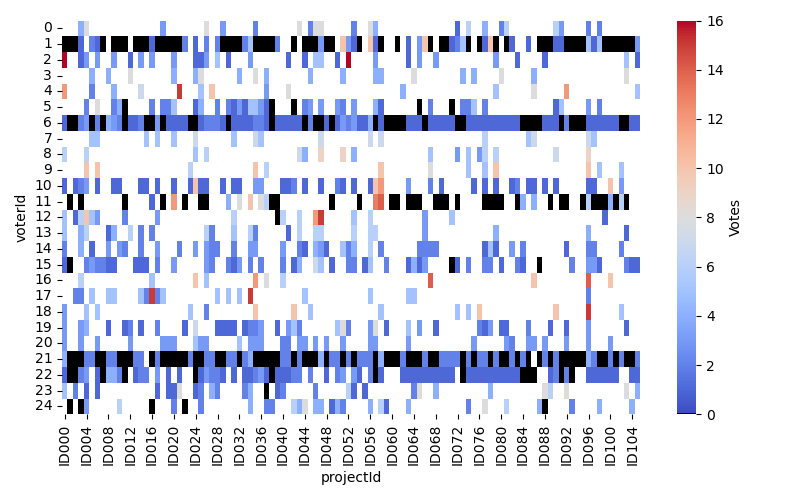

In [74]:
save_fp = os.path.join(save_folder, 'votes_raw_heatmap.png')
create_votes_raw_heatmap(df_nofilter, save_fp=save_fp)

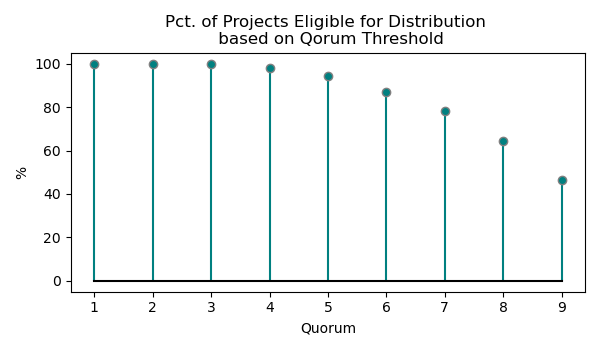

In [75]:
save_fp = os.path.join(save_folder, 'pct_eligible_fn_quorum.png')
votes2projectcdf(figsize=(6,3.5), save_fp=save_fp)

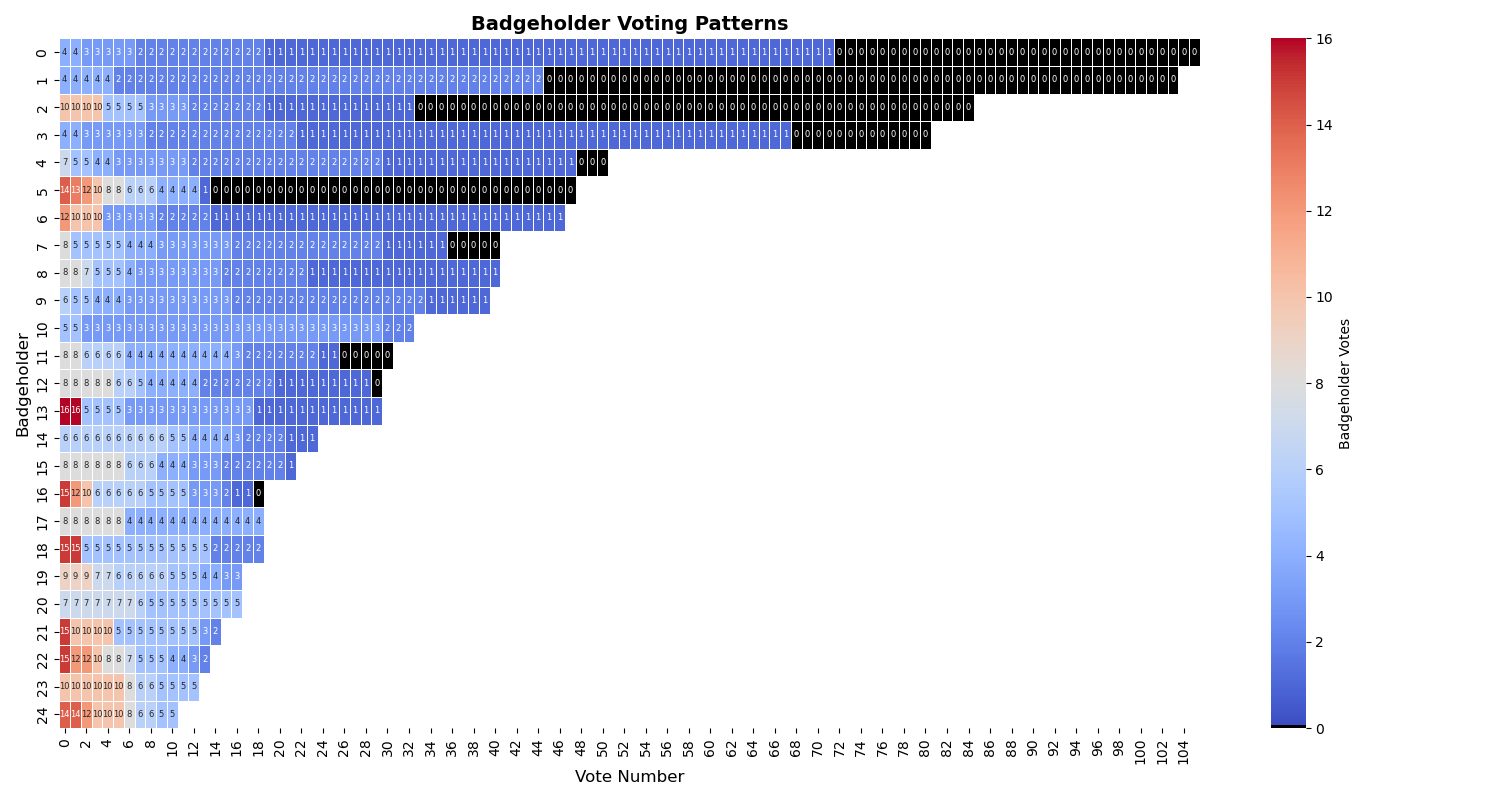

In [76]:
save_fp = os.path.join(save_folder, 'badgeholder_patterns_ragged2.png')
badgeholder_patterns2(df_nofilter, figsize=(15, 8), save_fp=save_fp)

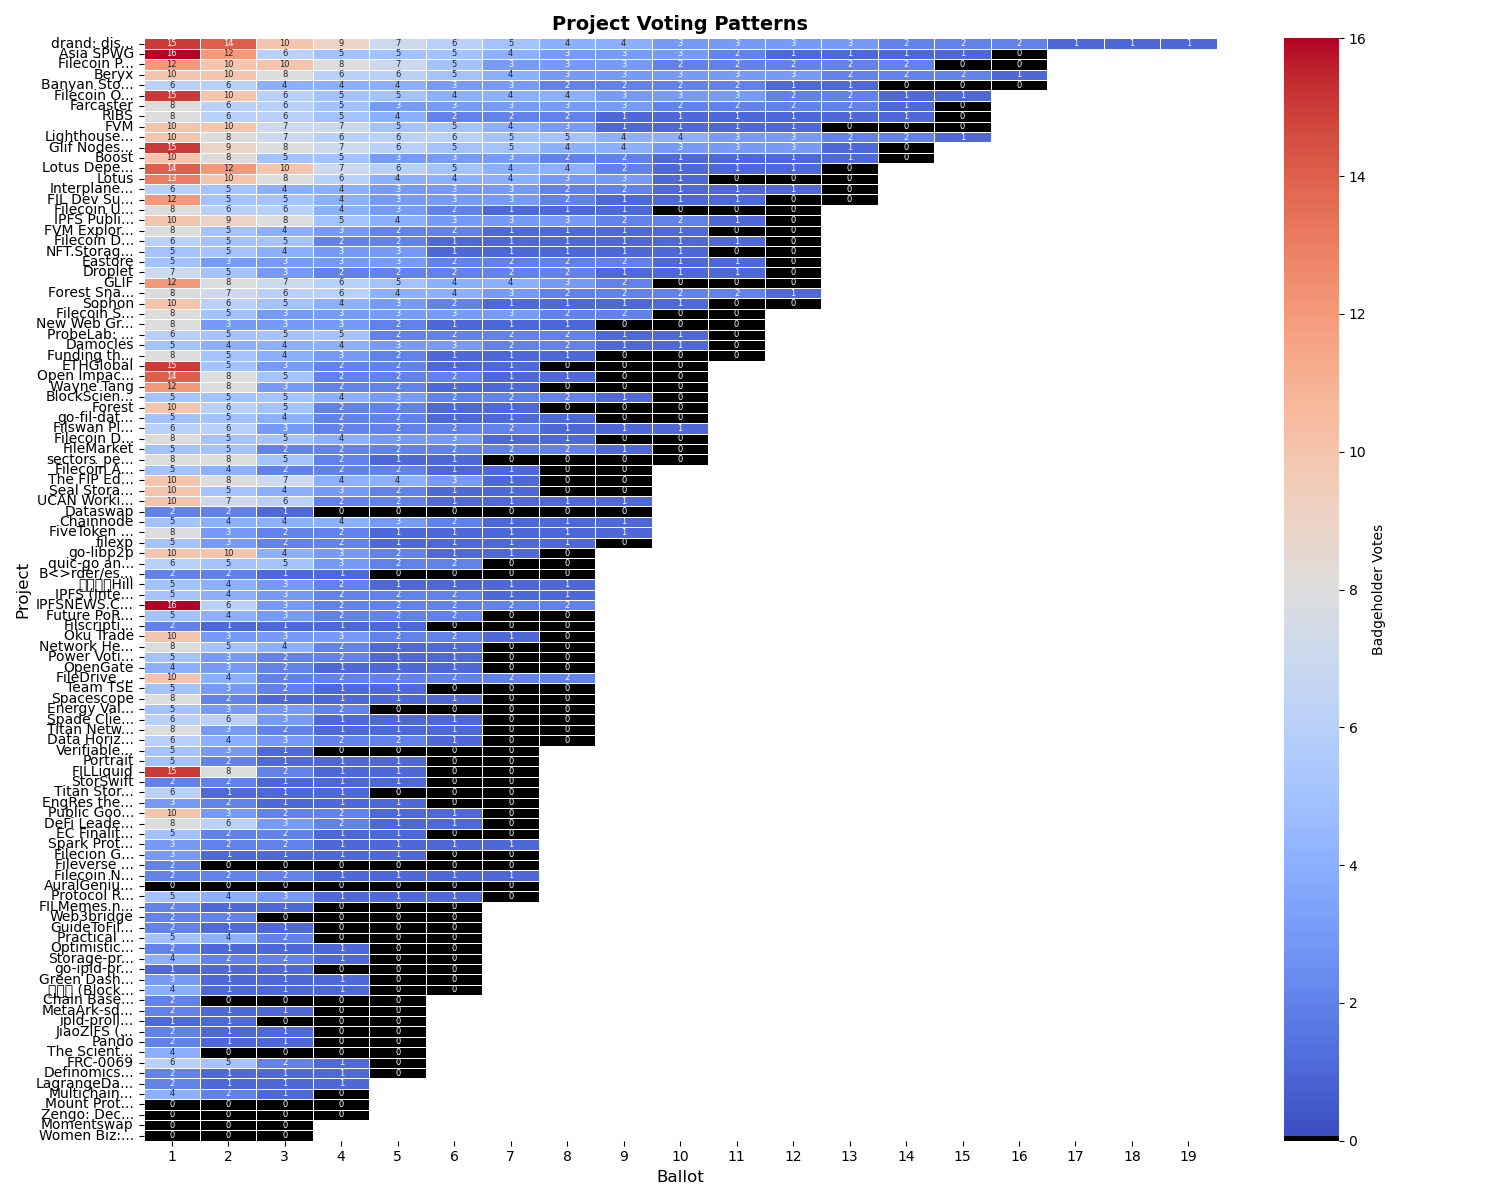

In [114]:
save_fp = os.path.join(save_folder, 'project_patterns_ragged2.png')
project_patterns_withname(df_nofilter, figsize=(15, 12), save_fp=save_fp)

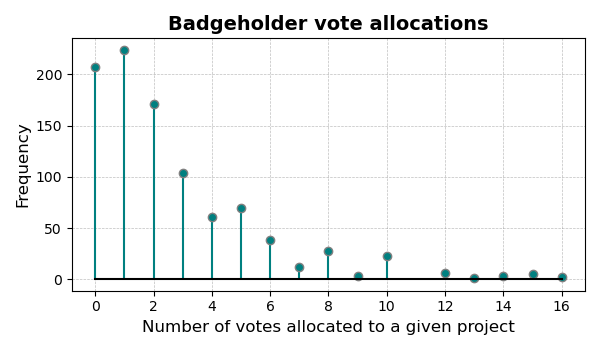

In [78]:
save_fp = os.path.join(save_folder, 'votes_per_project_hist.png')
votes_per_project_histogram(df_nofilter, figsize=(6, 3.5), save_fp=save_fp)

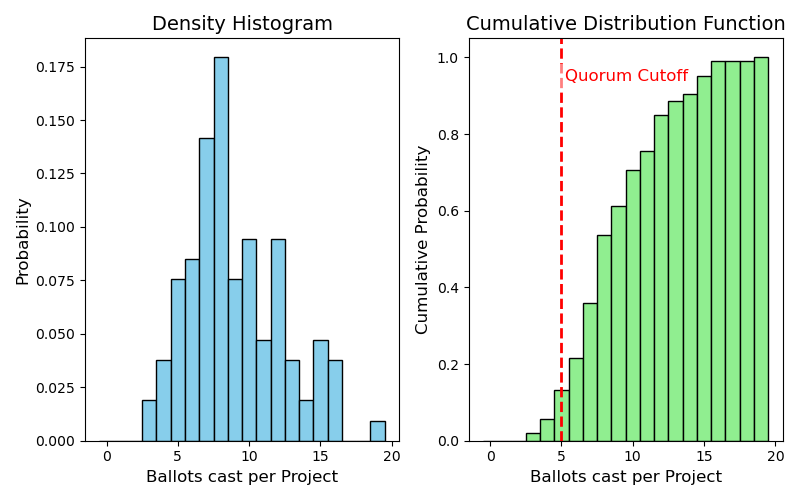

In [79]:
votes_distribution(df_nofilter, figsize=(8, 5), save_fp=os.path.join(save_folder, 'votes_distribution.png'))

In [80]:
gb = df_nofilter.groupby('voterId')
voter2votes = {}
for k, v in gb:
    voter2votes[k] = np.sum(v['amount'].values)
voter2votes
# print(np.asarray(list(voter2votes.values())).sum())

{0: 100,
 1: 100,
 2: 100,
 3: 100,
 4: 100,
 5: 100,
 6: 100,
 7: 100,
 8: 100,
 9: 100,
 10: 100,
 11: 100,
 12: 100,
 13: 100,
 14: 100,
 15: 100,
 16: 100,
 17: 100,
 18: 100,
 19: 100,
 20: 100,
 21: 100,
 22: 100,
 23: 100,
 24: 99}

### Allocation Distributions

#### Allocation Distribution as a function Mean/Median, Strictly Postive vs. Positive

235.45999000999007
mean > False >> # projects not meeting quorum: 6 >> total projects: 106
10 4
25 12
50 30
75 53
100 98


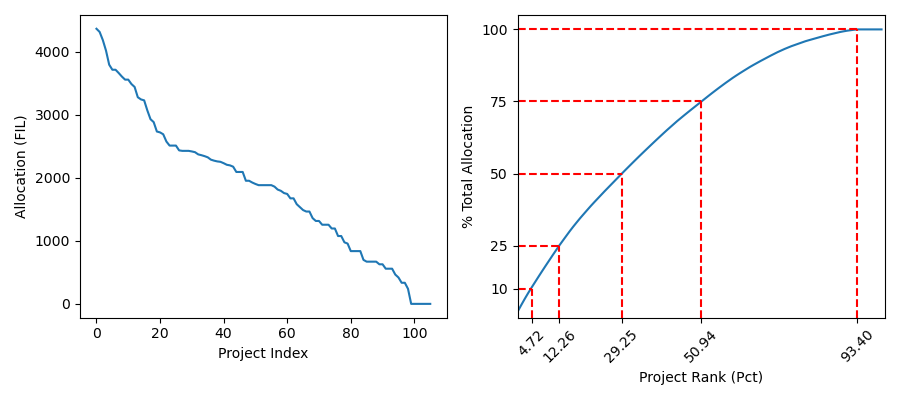

In [81]:
# allocation distributions
#score_fns = [np.mean, np.median]
score_fns = [np.mean]
quorum_strictly_positive = [False]

simulation_configs = list(itertools.product(score_fns, quorum_strictly_positive))
cfg2distribution = {}
cfg2normalized_score = {}
for cfg in simulation_configs:
    score_fn, quorum_strictly_positive = cfg
    cfg_str = f'{score_fn.__name__}_quorum_SP_{quorum_strictly_positive}'
    _, project2score_normalized, project2distribution, _ = project2allocation(
        df_nofilter, 
        score_fn=score_fn, 
        quorum=5, 
        quorum_strictly_positive=quorum_strictly_positive
    )
    cfg2distribution[cfg_str] = project2distribution
    cfg2normalized_score[cfg_str] = project2score_normalized


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,4))

# axx = ax[0]
axx = ax[0]
data=np.sort(np.asarray(list(cfg2distribution['mean_quorum_SP_False'].values())))[::-1]
axx.plot(np.arange(len(data)), data)
# axx.legend(title='Scoring Configuration')
axx.set_xlabel('Project Index')
axx.set_ylabel('Allocation (FIL)')

axx = ax[1]
total_fil = np.sum(data)
xx = data.cumsum()/total_fil * 100
axx.plot(np.arange(len(data)), xx)

pct = [10, 25, 50, 75, 100]
xticks = []
xticklabs = []
yticklabs = []
for p in pct:
    # find the closest index to this pct
    ix = np.argmin(np.abs(xx - p))
    print(p, ix)

    axx.vlines(ix, 0, p, color='r', linestyle='--')
    axx.hlines(p, 0, ix, color='r', linestyle='--')
    # axx.text(ix, p, f'{p}%', color='r', fontsize=10, ha='right')
    # put a label on the axis for this pct
    # axx.text(ix, 0, f'{ix}', color='k', fontsize=10, va='bottom')
    xticks.append(ix)
    xticklabs.append('%0.02f' % ((ix+1)/len(data) * 100,))
    yticklabs.append(p)

# axx.legend(title='Scoring Configuration')
axx.set_ylim(0, 105)
axx.set_xlim(0, len(data))
# axx.set_xticklabels(xticklabs)
axx.set_xticks(xticks)
axx.set_xticklabels(xticklabs, rotation=45)
axx.set_yticks(yticklabs)
axx.set_xlabel('Project Rank (Pct)')
axx.set_ylabel('% Total Allocation')

plt.tight_layout()
save_fp = os.path.join(save_folder, 'allocation_distributions_final.png')
plt.savefig(save_fp)

213.0389582639583
mean > True >> # projects not meeting quorum: 30 >> total projects: 106
235.45999000999007
mean > False >> # projects not meeting quorum: 6 >> total projects: 106


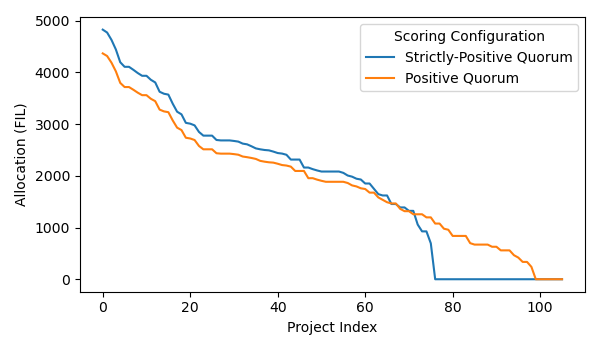

In [82]:
# allocation distributions
#score_fns = [np.mean, np.median]
score_fns = [np.mean]
quorum_strictly_positive = [True, False]

simulation_configs = list(itertools.product(score_fns, quorum_strictly_positive))
cfg2distribution = {}
cfg2normalized_score = {}
for cfg in simulation_configs:
    score_fn, quorum_strictly_positive = cfg
    cfg_str = f'{score_fn.__name__}_quorum_SP_{quorum_strictly_positive}'
    _, project2score_normalized, project2distribution, _ = project2allocation(
        df_nofilter, 
        score_fn=score_fn, 
        quorum=5, 
        quorum_strictly_positive=quorum_strictly_positive
    )
    cfg2distribution[cfg_str] = project2distribution
    cfg2normalized_score[cfg_str] = project2score_normalized


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,3.5))

# axx = ax[0]
axx = ax
data=np.sort(np.asarray(list(cfg2distribution['mean_quorum_SP_True'].values())))[::-1]
axx.plot(np.arange(len(data)), data, label='Strictly-Positive Quorum')
data=np.sort(np.asarray(list(cfg2distribution['mean_quorum_SP_False'].values())))[::-1]
axx.plot(np.arange(len(data)), data, label='Positive Quorum')
# data=np.sort(np.asarray(list(cfg2distribution['mean_quorum_SP_True'].values())))[::-1]
# axx.plot(np.arange(len(data)), data, label='Mean/Strictly-Positive Quorum')
# data=np.sort(np.asarray(list(cfg2distribution['mean_quorum_SP_False'].values())))[::-1]
# axx.plot(np.arange(len(data)), data, label='Mean/Positive Quorum')
# data=np.sort(np.asarray(list(cfg2distribution['median_quorum_SP_True'].values())))[::-1]
# axx.plot(np.arange(len(data)), data, label='Median/Strictly-Positive Quorum')
# data=np.sort(np.asarray(list(cfg2distribution['median_quorum_SP_False'].values())))[::-1]
# axx.plot(np.arange(len(data)), data, label='Median/Positive Quorum')
axx.legend(title='Scoring Configuration')
axx.set_xlabel('Project Index')
axx.set_ylabel('Allocation (FIL)')

plt.tight_layout()
save_fp = os.path.join(save_folder, 'allocation_distributions_pos_strictpos.png')
plt.savefig(save_fp)

########## Minimum Allocation: 0 ##########
235.45999000999007
mean > False >> # projects not meeting quorum: 6 >> total projects: 106
All projects meet the minimum allocation criteria on Iteration 1!!
Total FIL distributed: 197119.9999999998
##############################
########## Minimum Allocation: 500 ##########
235.45999000999007
mean > False >> # projects not meeting quorum: 6 >> total projects: 106
Iteration 1: Removed 12 projects
Remove list:
['ID001', 'ID007', 'ID011', 'ID038', 'ID055', 'ID060', 'ID061', 'ID062', 'ID094', 'ID095', 'ID099', 'ID101']
233.31872016872023
mean > False >> # projects not meeting quorum: 0 >> total projects: 94
All projects meet the minimum allocation criteria on Iteration 2!!
Total FIL distributed: 197120.0
##############################
########## Minimum Allocation: 1000 ##########
235.45999000999007
mean > False >> # projects not meeting quorum: 6 >> total projects: 106
Iteration 1: Removed 28 projects
Remove list:
['ID001', 'ID002', 'ID007', 'I

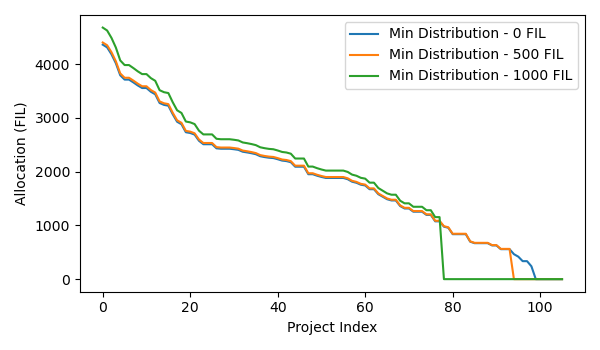

In [83]:
min_alloc_vec = [0, 500, 1000]
cfg2distribution_min = {}
for min_alloc in min_alloc_vec:
    print("#"*10, f'Minimum Allocation: {min_alloc}', "#"*10)
    _, _, project2distribution_ma, _ = project2allocation_withminscore(
        df_nofilter, 
        score_fn=score_fn, 
        quorum=5, 
        quorum_strictly_positive=False,
        min_alloc=min_alloc
    )
    cfg2distribution_min[min_alloc] = project2distribution_ma
    print("#"*30)

_, _, project2distribution_strictlypositive_nominalloc, _ = project2allocation_withminscore(
    df_nofilter, 
    score_fn=score_fn, 
    quorum=5, 
    quorum_strictly_positive=True,
    min_alloc=0
)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,3.5))

# axx = ax[0]
axx = ax
for min_alloc in min_alloc_vec:
    data=np.sort(np.asarray(list(cfg2distribution_min[min_alloc].values())))[::-1]
    # since we filtered, pad the remaining projects w/ zero so that plots are systematic
    data = np.pad(data, (0, len(project2distribution_strictlypositive_nominalloc) - len(data)), 'constant')
    axx.plot(np.arange(len(data)), data, label=f'Min Distribution - {min_alloc} FIL')
    

# data=np.sort(np.asarray(list(project2distribution_strictlypositive_nominalloc.values())))[::-1]
# axx.plot(np.arange(len(data)), data, label=f'0 FIL/Strictly-Positive Quorum', linestyle=':', color='black')

axx.legend()
axx.set_xlabel('Project Index')
axx.set_ylabel('Allocation (FIL)')

plt.tight_layout()
plt.savefig(os.path.join(save_folder, 'allocation_distributions_minalloc.png'))

235.45999000999007
mean > False >> # projects not meeting quorum: 6 >> total projects: 106
173.0
median > False >> # projects not meeting quorum: 6 >> total projects: 106
1264.3981559461527
quad > False >> # projects not meeting quorum: 6 >> total projects: 106


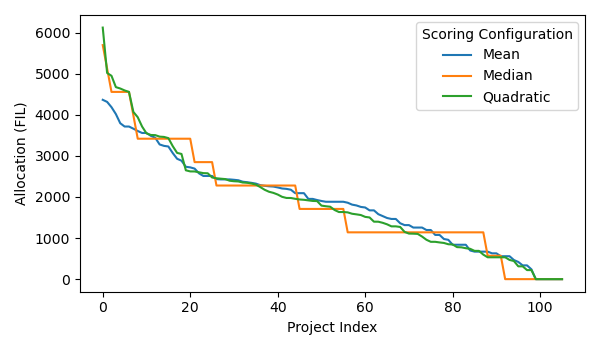

In [84]:
# allocation distributions
#score_fns = [np.mean, np.median]
def quad(x):
    return np.sum(np.sqrt(x))
score_fns = [np.mean, np.median, quad]
quorum_strictly_positive = [False]

simulation_configs = list(itertools.product(score_fns, quorum_strictly_positive))
cfg2distribution = {}
cfg2normalized_score = {}
for cfg in simulation_configs:
    score_fn, quorum_strictly_positive = cfg
    cfg_str = f'{score_fn.__name__}_quorum_SP_{quorum_strictly_positive}'
    _, project2score_normalized, project2distribution, _ = project2allocation(
        df_nofilter, 
        score_fn=score_fn, 
        quorum=5, 
        quorum_strictly_positive=quorum_strictly_positive
    )
    cfg2distribution[cfg_str] = project2distribution
    cfg2normalized_score[cfg_str] = project2score_normalized


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,3.5))

# axx = ax[0]
axx = ax
data=np.sort(np.asarray(list(cfg2distribution['mean_quorum_SP_False'].values())))[::-1]
axx.plot(np.arange(len(data)), data, label='Mean')
data=np.sort(np.asarray(list(cfg2distribution['median_quorum_SP_False'].values())))[::-1]
axx.plot(np.arange(len(data)), data, label='Median')
data=np.sort(np.asarray(list(cfg2distribution['quad_quorum_SP_False'].values())))[::-1]
axx.plot(np.arange(len(data)), data, label='Quadratic')
axx.legend(title='Scoring Configuration')
axx.set_xlabel('Project Index')
axx.set_ylabel('Allocation (FIL)')

plt.tight_layout()
save_fp = os.path.join(save_folder, 'allocation_distributions_meanmedquad.png')
plt.savefig(save_fp)

235.45999000999007
mean > False >> # projects not meeting quorum: 6 >> total projects: 106
10.490727193361895


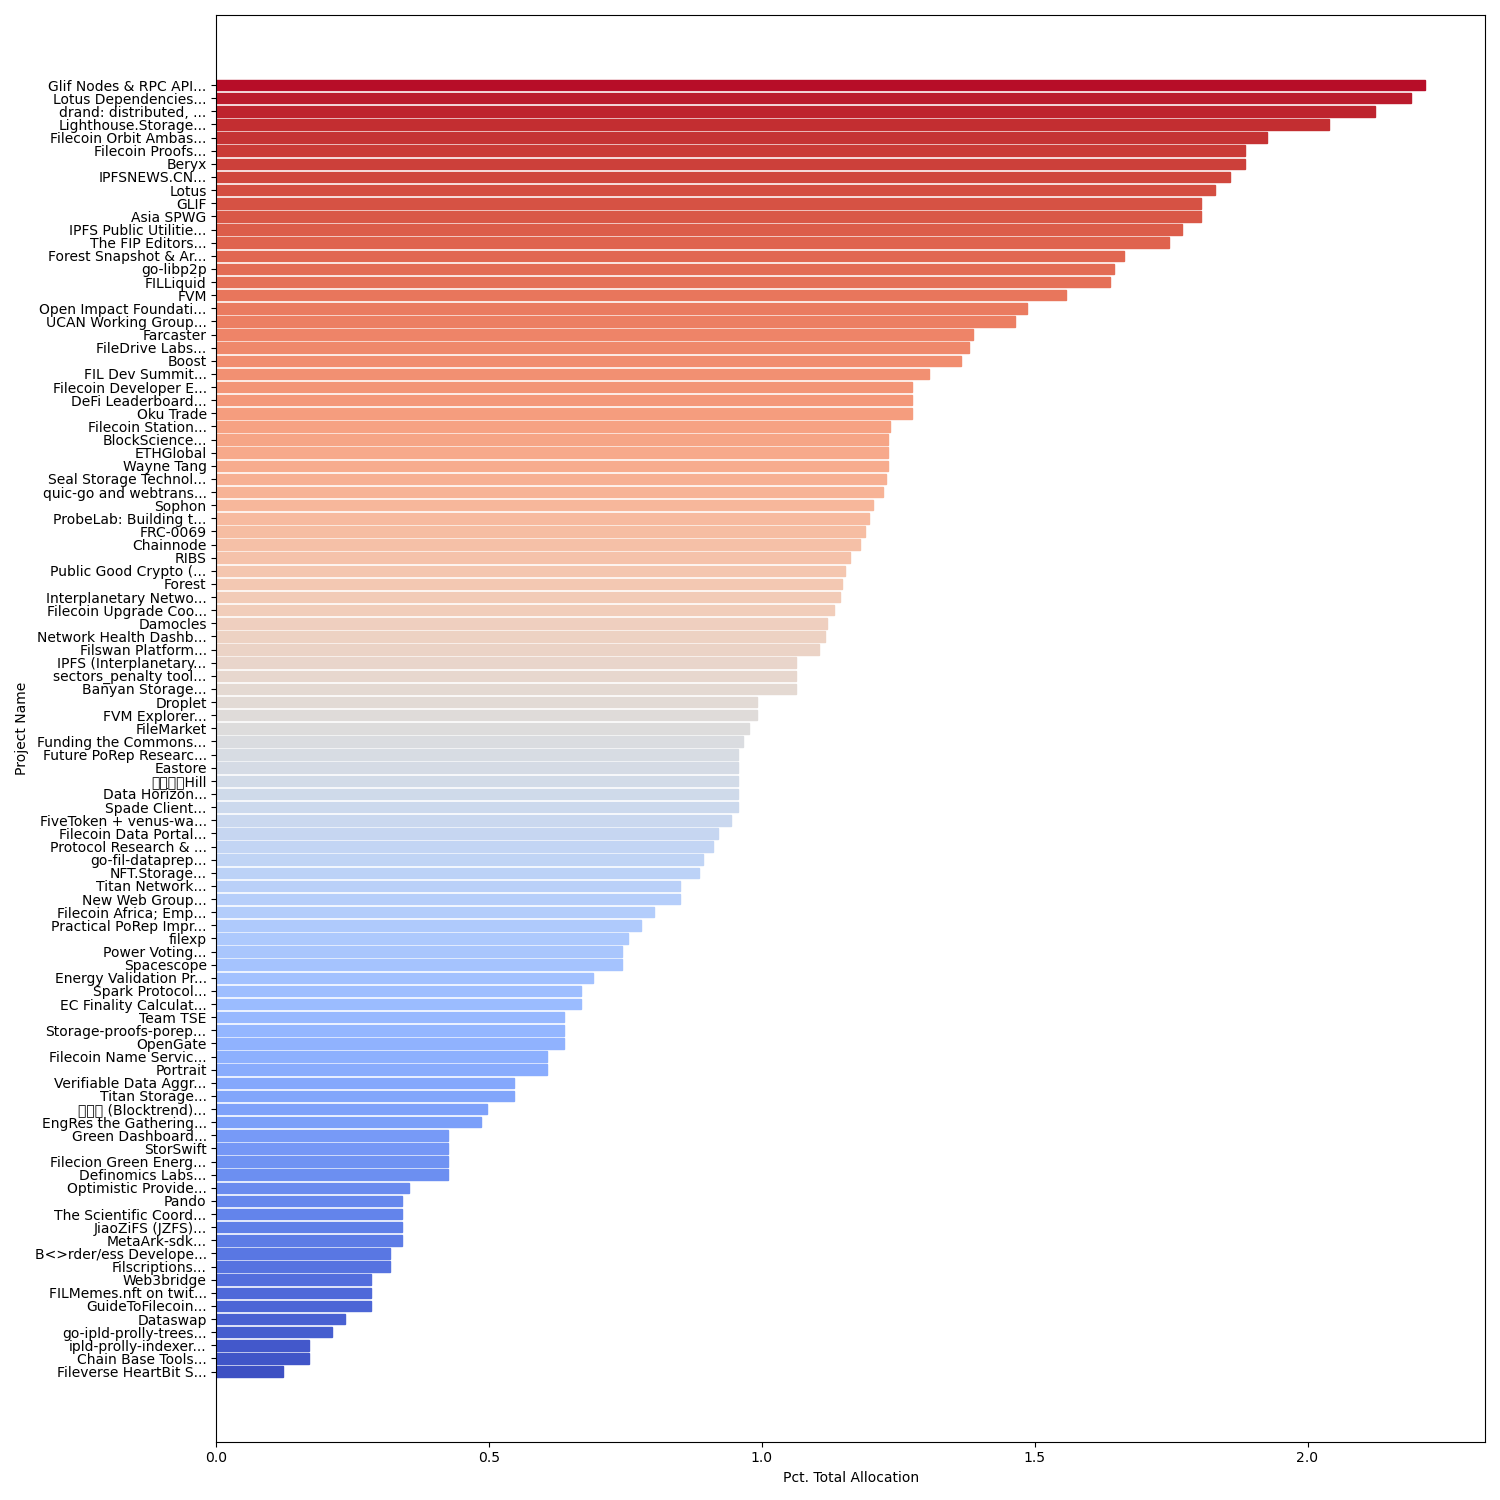

In [85]:
## plot the relative allocation of funds to each project with the project name (de-anon)
id2name, project2score_normalized, project2distribution, full_results_df = project2allocation(
        df_nofilter, 
        score_fn=np.mean, 
        quorum=5, 
        quorum_strictly_positive=False
    )
name2distribution = {}
total_distributed = 0
for k,v in project2distribution.items():
    if v > 0:
        name2distribution[id2name[k]] = v
        total_distributed += v
name2relativedistribution = {}
for k,v in name2distribution.items():
    name2relativedistribution[k] = v / total_distributed * 100
# make a bar plot of name to relative distribution
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
data = np.asarray(list(name2relativedistribution.values()))
names = list(name2relativedistribution.keys())
ix = np.argsort(data)
data = data[ix]
print(data[-5:].sum())
names = []
for i in ix:
    n = list(name2relativedistribution.keys())[i]
    names.append(n[0:20] + '...' if len(n) > 10 else n)

palette = sns.color_palette("coolwarm", n_colors=len(data))
bars = ax.barh(names, data)
for i, bar in enumerate(bars):  # data is already sorted
    bar.set_color(palette[i])
    
ax.set_xlabel('Pct. Total Allocation')
ax.set_ylabel('Project Name')
plt.tight_layout()
save_fp = os.path.join(save_folder, 'allocation_relative.png')
plt.savefig(save_fp)

In [86]:
full_results_df_sorted = full_results_df.sort_values('FIL Received', ascending=False)
save_fp = os.path.join(save_folder, 'allocation_results.csv')
full_results_df_sorted.to_csv(save_fp, index=False)

In [87]:
full_results_df_sorted

,Project Name,Ballots,Score,Quorum reached,FIL Received,Project URL
47,Glif Nodes & RPC API service,14,5.214286,True,4365.242689,https://fil-retropgf.io/projects/0x005bcf117de...
58,Lotus Dependencies,13,5.153846,True,4314.644513,https://fil-retropgf.io/projects/0x20b54ce1a10...
96,"drand: distributed, verifiable randomness",19,5.000000,True,4185.849154,https://fil-retropgf.io/projects/0x3058eb34788...
56,Lighthouse.Storage,15,4.800000,True,4018.415188,https://fil-retropgf.io/projects/0x9096256fd62...
34,Filecoin Orbit Ambassadors,15,4.533333,True,3795.169900,https://fil-retropgf.io/projects/0xcf273ad1694...
...,...,...,...,...,...,...
95,Zengo: Decentralized Budget,4,0.000000,False,0.000000,https://fil-retropgf.io/projects/0x443dcf92e2a...
55,LagrangeDao,4,0.000000,False,0.000000,https://fil-retropgf.io/projects/0x307859b0150...
60,Momentswap,3,0.000000,False,0.000000,https://fil-retropgf.io/projects/0x4955aed0f3c...
61,Mount Protocol,4,0.000000,False,0.000000,https://fil-retropgf.io/projects/0xa5fe2de856b...


#### Allocation Distribution for Mean/False as a function of Quorum

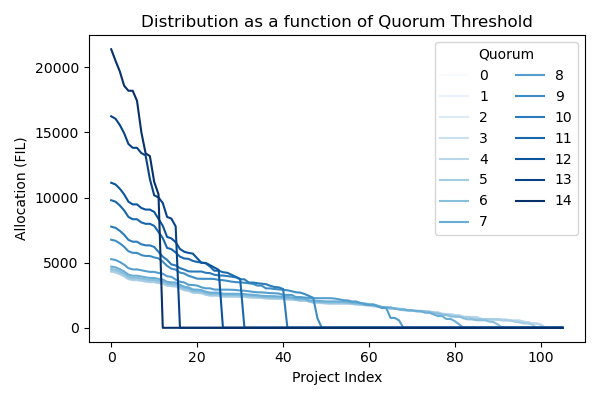

In [121]:
# plot allocation distribution as a function of qourum

quorom_vec = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
cm = mpl.colormaps['Blues'](np.linspace(0, 1, len(quorom_vec)))

q2distribution = {}
for q in quorom_vec:
    score_fn = np.mean
    quorum_strictly_positive = False
    _, project2score_normalized, project2distribution, _ = project2allocation(
        df_nofilter,
        score_fn=score_fn, 
        quorum=q, 
        quorum_strictly_positive=quorum_strictly_positive
    )
    q2distribution[q] = project2distribution

# plot the distributions
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,4))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

# axx = ax[0]
axx = ax
for i, q in enumerate(quorom_vec):
    data=np.sort(np.asarray(list(q2distribution[q].values())))[::-1]
    axx.plot(np.arange(len(data)), data, label=f'{q}', color=cm[i])

axx.legend(title='Quorum', loc='upper right', ncol=2)
axx.set_xlabel('Project Index')
axx.set_ylabel('Allocation (FIL)')
axx.set_title('Distribution as a function of Quorum Threshold')

plt.tight_layout()
save_fp = os.path.join(save_folder, 'allocation_distributions_as_function_of_quorum.png')
plt.savefig(save_fp)

### Investigate how the distribution would have changed had we updated badgeholders

In [89]:
voter2votes = get_votes_by_badgeholder(df_nofilter)
# get stats on the number of votes per badgeholder
num_votes_per_badgeholder = np.asarray([len(v) for v in voter2votes.values()])
print(num_votes_per_badgeholder.mean(), num_votes_per_badgeholder.std())
qvec = np.percentile(num_votes_per_badgeholder, [5, 25, 50, 75, 95])
print(qvec)
# print(np.percentile(num_votes_per_badgeholder, 25), np.percentile(num_votes_per_badgeholder, 50), np.percentile(num_votes_per_badgeholder, 75))

38.32 27.192234185517012
[ 13.2  19.   30.   47.  100.2]


14.4 83.4
244.60647546897547
mean > False >> # projects not meeting quorum: 33 >> total projects: 105
214.928313190078
mean > False >> # projects not meeting quorum: 7 >> total projects: 106
215.58770673770667
mean > False >> # projects not meeting quorum: 36 >> total projects: 105


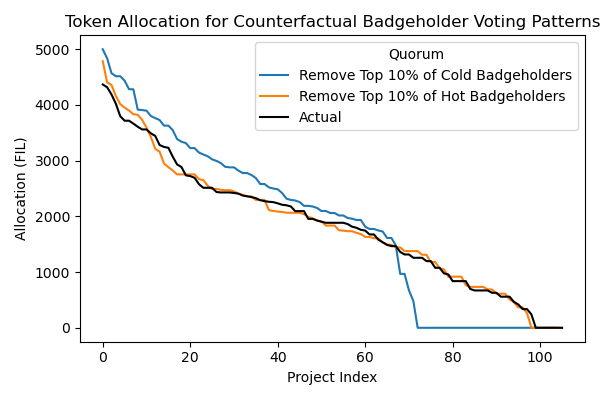

In [90]:
#### Allocation Distribution if we remove badgeholders who voted very concentrated, dispersed, and both

lb = np.percentile(num_votes_per_badgeholder, 10)
ub = np.percentile(num_votes_per_badgeholder, 90)

print(lb, ub)

df_remove_dispersed = filter_badgeholders_by_numvotes(
    df_nofilter, 
    min_votes=None, 
    max_votes=ub
)
df_remove_concentrated = filter_badgeholders_by_numvotes(
    df_nofilter, 
    min_votes=lb, 
    max_votes=None
)
df_remove_both = filter_badgeholders_by_numvotes(
    df_nofilter, 
    min_votes=lb, 
    max_votes=ub
)

# experiment settings
score_fn = np.mean
quorum_strictly_positive = False
quorum = 5

# plot allocation distribution as a function of qourum
_, _, remove_dispersed_distribution, _ = project2allocation(
    df_remove_dispersed,
    score_fn=score_fn, 
    quorum=quorum, 
    quorum_strictly_positive=quorum_strictly_positive
)
_, _, remove_concentrated_distribution, _ = project2allocation(
    df_remove_concentrated,
    score_fn=score_fn, 
    quorum=quorum, 
    quorum_strictly_positive=quorum_strictly_positive
)
_, _, remove_both_distribution, _ = project2allocation(
    df_remove_both,
    score_fn=score_fn, 
    quorum=quorum, 
    quorum_strictly_positive=quorum_strictly_positive
)

# plot the distributions
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,4))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

# axx = ax[0]
axx = ax
data=np.sort(np.asarray(list(remove_dispersed_distribution.values())))[::-1]
axx.plot(np.arange(len(data)), data, label=f'Remove Top 10% of Cold Badgeholders')
data=np.sort(np.asarray(list(remove_concentrated_distribution.values())))[::-1]
axx.plot(np.arange(len(data)), data, label=f'Remove Top 10% of Hot Badgeholders')
# data=np.sort(np.asarray(list(remove_both_distribution.values())))[::-1]
# axx.plot(np.arange(len(data)), data, label=f'Remove Badgeholders ID:0-2, 22-24')
data=np.sort(np.asarray(list(cfg2distribution['mean_quorum_SP_False'].values())))[::-1]
axx.plot(np.arange(len(data)), data, label='Actual', color='k')

axx.legend(title='Quorum')
axx.set_xlabel('Project Index')
axx.set_ylabel('Allocation (FIL)')
axx.set_title('Token Allocation for Counterfactual Badgeholder Voting Patterns')

plt.tight_layout()

save_fp = os.path.join(save_folder, 'allocation_distribution_counterfactual_voting_patterns.png')
plt.savefig(save_fp)

In [91]:
delta_total = 0
for k, v, in project2distribution.items():
    delta_total += v - int(v)
print(delta_total)

25.000000000006594


235.45999000999007
mean > False >> # projects not meeting quorum: 6 >> total projects: 106
cat2total {'Edu & Outreach': 40138.34635802732, 'Infra & Deps': 60192.62002347143, 'Protocol R&D': 29607.03749219125, 'Governance': 12229.655945133147, 'Tools & Utilities': 32186.666347987994, 'Product & UX': 19312.348281083345, 'Other': 3453.325552105481}
cat2numfunded {'Edu & Outreach': 22, 'Protocol R&D': 15, 'Infra & Deps': 23, 'Governance': 6, 'Tools & Utilities': 19, 'Product & UX': 12, 'Other': 2}
cat2avgfunding {'Edu & Outreach': 1824.4702890012416, 'Infra & Deps': 2617.0704358031057, 'Protocol R&D': 1973.8024994794168, 'Governance': 2038.2759908555245, 'Tools & Utilities': 1694.0350709467366, 'Product & UX': 1609.3623567569455, 'Other': 1726.6627760527406}
avg per project 1859.6226415094336
cat2pctchange {'Edu & Outreach': -1.8902949299251004, 'Infra & Deps': 40.73126328892515, 'Protocol R&D': 6.139947719570934, 'Governance': 9.606967852417633, 'Tools & Utilities': -8.904364082612565, 'P

/tmp/ipykernel_44664/3103413702.py:63: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_44664/3103413702.py:74: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_44664/3103413702.py:85: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




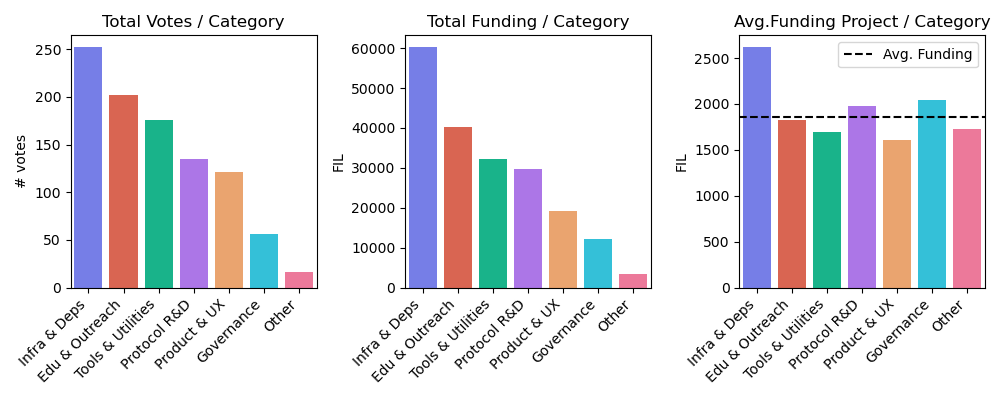

In [109]:
# rename categories for better plotting
category_mapping = {
    'Infrastructure & Dependencies': 'Infra & Deps',
    'Education & Outreach': 'Edu & Outreach',
    'Protocol R&D': 'Protocol R&D',
    'Tooling & Utilities': 'Tools & Utilities',
    'Collective Governance': 'Governance',
    'Product & End User UX': 'Product & UX',
    'Other': 'Other',
}
df_nofilter['category_short'] = df_nofilter['category'].map(category_mapping)
colors = [
    "#636efa",
    "#EF553B",
    "#00cc96",
    "#ab63fa",
    "#FFA15A",
    "#19d3f3",
    "#FF6692",
]

# get project2allocation for final configuration
_, project2score_normalized, project2distribution, _ = project2allocation(df_nofilter, score_fn=np.mean, quorum=5, quorum_strictly_positive=False)
cat2total = {}
cat2numfundedprojects = {}
for k, v, in project2distribution.items():
    name = df_nofilter[df_nofilter['projectId'] == k]['project'].values[0]
    cat_full = df_nofilter[df_nofilter['projectId'] == k]['category'].values[0]
    cat = df_nofilter[df_nofilter['projectId'] == k]['category_short'].values[0]
    if cat not in cat2total:
        cat2total[cat] = 0
    cat2total[cat] += v

    if v > 0:
        if cat not in cat2numfundedprojects:
            cat2numfundedprojects[cat] = 0
        cat2numfundedprojects[cat] += 1

cat2avgfunding = {}
for k in cat2total.keys():
    cat2avgfunding[k] = cat2total[k] / cat2numfundedprojects[k]
print('cat2total', cat2total)
print('cat2numfunded', cat2numfundedprojects)
print('cat2avgfunding', cat2avgfunding)
avg_funding_per_project = np.mean(list(project2distribution.values()))
print('avg per project', avg_funding_per_project)
# compute pct change from avg funding per project
cat2pctchange = {}
for k in cat2avgfunding.keys():
    cat2pctchange[k] = (cat2avgfunding[k] - avg_funding_per_project) / avg_funding_per_project * 100
print('cat2pctchange', cat2pctchange)

# cm = sns.color_palette("flare")
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,4))
axx = ax[0]
# axx.bar(df_detailed['Category'].value_counts().index, df_detailed['Category'].value_counts().values)
xx = df_nofilter['category_short'].value_counts().index
yy = df_nofilter['category_short'].value_counts().values
cat2votes_dict = dict(zip(xx, yy))
sorted_indices = np.argsort(yy)[::-1]
xx = xx[sorted_indices]
yy = yy[sorted_indices]
sns.barplot(x=xx, y=yy, ax=axx, palette=colors)
axx.set_title('Total Votes / Category')
axx.set_ylabel('# votes')
axx.set_xlabel('')
axx.tick_params(axis='x', labelrotation=45)
axx.set_xticklabels(axx.get_xticklabels(), ha='right')

axx = ax[1]
yy = []
for k in xx:
    yy.append(cat2total[k])
sns.barplot(x=xx, y=yy, ax=axx, palette=colors)
axx.set_title('Total Funding / Category')
axx.set_ylabel('FIL')
axx.set_xlabel('')
axx.tick_params(axis='x', labelrotation=45)
axx.set_xticklabels(axx.get_xticklabels(), ha='right')

axx = ax[2]
yy = []
for k in xx:
    yy.append(cat2avgfunding[k])
sns.barplot(x=xx, y=yy, ax=axx, palette=colors)

axx.axhline(avg_funding_per_project, linestyle='--', color='k', label='Avg. Funding')
axx.legend()
axx.set_title('Avg.Funding Project / Category')
axx.set_ylabel('FIL')
axx.set_xlabel('')
axx.tick_params(axis='x', labelrotation=45)
axx.set_xticklabels(axx.get_xticklabels(), ha='right')

plt.tight_layout()

save_fp = os.path.join(save_folder, 'votes_funding_per_category.png')
plt.savefig(save_fp)
# plt.xticks(rotation=45)

/tmp/ipykernel_44664/2613113165.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




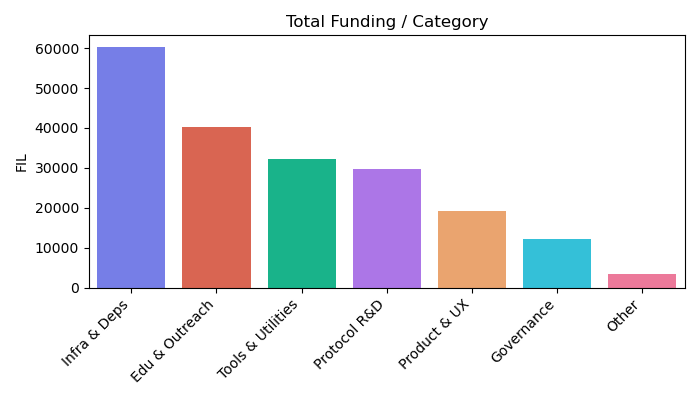

In [110]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,4))
axx = ax
# axx.bar(df_detailed['Category'].value_counts().index, df_detailed['Category'].value_counts().values)
xx = df_nofilter['category_short'].value_counts().index
yy = df_nofilter['category_short'].value_counts().values
cat2votes_dict = dict(zip(xx, yy))
sorted_indices = np.argsort(yy)[::-1]
xx = xx[sorted_indices]
yy = []
for k in xx:
    yy.append(cat2total[k])
sns.barplot(x=xx, y=yy, ax=axx, palette=colors)
axx.set_title('Total Funding / Category')
axx.set_ylabel('FIL')
axx.set_xlabel('')
axx.tick_params(axis='x', labelrotation=45)
axx.set_xticklabels(axx.get_xticklabels(), ha='right')

plt.tight_layout()
plt.savefig(os.path.join(save_folder, 'funding_per_category_only.png'))

In [122]:
# name2relativedistribution
import plotly.graph_objects as go
import plotly.express as px
import chart_studio.plotly as py
import chart_studio
import json

with open(os.path.join(os.environ['HOME'], 'code', 'cel', 'auth', 'plotly.json'), 'r') as fp:
    plotly_auth = json.load(fp)
chart_studio.tools.set_credentials_file(username=plotly_auth['username'], api_key=plotly_auth['api_key'])

dict_list = []
for k,v in name2relativedistribution.items():
    cat = df_nofilter[df_nofilter['project'] == k]['category_short'].values[0]
    dict_list.append({
        'Project Name': k, 
        'Pct. Total Allocation': v,
        'Category': cat
    })
df_plotly = pd.DataFrame(dict_list)
df_plotly = df_plotly.sort_values('Pct. Total Allocation', ascending=False)

fig = px.sunburst(
    df_plotly, 
    path=['Category', 'Project Name'], 
    values='Pct. Total Allocation',
    hover_data=['Pct. Total Allocation'],
)
fig.show()
py.plot(fig, filename="project_relative_distribution")

'https://plotly.com/~k2ncsu/1/'

Opening in existing browser session.


In [ ]:
print('max scoring project', max(list(project2distribution.values())))
print('mean of funding across all projects', np.mean(np.asarray(list(project2distribution.values()))))
# print(np.median(np.asarray(list(project2distribution.values()))))

# find average scoring project and how much FIL did it get
project_scores = np.asarray(list(project2score_normalized.values()))
mean_score = np.mean(project_scores)
# find project which has the closest score to the mean
closest_project = min(project2score_normalized, key=lambda x: abs(project2score_normalized[x] - mean_score))
print('mean scoring project', closest_project, project2distribution[closest_project], 'mean_score', mean_score)

# find median scoring project and how much FIL did it get
median_score = np.median(project_scores)
# find project which has the closest score to the median
closest_project = min(project2score_normalized, key=lambda x: abs(project2score_normalized[x] - median_score))
print('median scoring project', closest_project, project2distribution[closest_project], 'median_score', median_score)

Opening in existing browser session.


In [ ]:
df_nofilter['category_short'].value_counts()

### Anomalies

In [ ]:
# is there a correlation w/ the # of votes a project got and its place in alphabetical order?

gb = df_nofilter.groupby('projectId')

project2votes = {}
for k, v, in gb:
    project2votes[k] = v['amount'].values

# create a list of projects sorted by alphabetical order
projects = list(project2votes.keys())
ix = np.argsort(projects)
projects_sorted = np.asarray(projects)[ix]
num_votes_sorted = np.asarray([len(project2votes[p]) for p in projects_sorted])
avg_votes_sorted = np.asarray([np.mean(project2votes[p]) for p in projects_sorted])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
axx = ax[0]
xx = np.arange(len(projects_sorted))
yy = num_votes_sorted
corr = scipy.stats.spearmanr(xx, yy)
axx.scatter(xx, yy)
axx.set_title(f'Correlation: {corr.statistic:.2f}')
axx.set_xlabel('Project Index')
axx.set_ylabel('Number of Votes')

axx = ax[1]
xx = np.arange(len(projects_sorted))
yy = avg_votes_sorted
corr = scipy.stats.spearmanr(xx, yy)
axx.scatter(xx, yy)
axx.set_title(f'Correlation: {corr.statistic:.2f}')
axx.set_xlabel('Project Index')
axx.set_ylabel('Average Vote')

plt.tight_layout()
save_fp = os.path.join(save_folder, 'anomalies.png')
plt.savefig(save_fp)

### Correlation between project scores and alphabetical position (since projects where alphabetically ordered on the site)

In [ ]:
# is there a correlation w/ the # of votes a project got and its place in alphabetical order?

gb = df_nofilter.groupby('projectId')

project2votes = {}
project2alphabet_pos = {}
for k, v, in gb:
    project2votes[k] = v['amount'].values
    project2alphabet_pos[k] = v['project_alphabet_pos'].values[0]

# create a list of projects sorted by alphabetical order
# projects = list(project2votes.keys())
projects = sorted(list(project2votes.keys()), key=str.lower)
ix = np.argsort(projects)
projects_sorted = np.asarray(projects)[ix]
num_votes_sorted = np.asarray([len(project2votes[p]) for p in projects_sorted])
total_votes_sorted = np.asarray([np.sum(project2votes[p]) for p in projects_sorted])
avg_votes_sorted = np.asarray([np.mean(project2votes[p]) for p in projects_sorted])
project2alphabet_pos_sorted = np.asarray([project2alphabet_pos[p] for p in projects_sorted])

df_reg = pd.DataFrame({"Project Index": ix, 
                       "projects_sorted": projects_sorted,  
                       "total_votes_sorted":  total_votes_sorted,
                       "avg_votes_sorted": avg_votes_sorted
                      })

df_reg['projects_alphabet_pos'] = project2alphabet_pos_sorted

df_corr = df_reg[['Project Index','total_votes_sorted', 'avg_votes_sorted', 'projects_alphabet_pos']].corr()
df_corr

In [ ]:
# Setup for side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Adjusted size for better visual space

# Plot settings
plot_settings = {
    'color': 'teal',  # Uniform color for all regression lines
    'line_kws': {'linewidth': 2, 'color': 'darkred'}  # Line settings
}

# First plot
xx = 'projects_alphabet_pos'
yy = 'total_votes_sorted'
title = df_corr.loc[yy, xx]
sns.regplot(x=xx, y=yy, data=df_reg, ax=axes[0], **plot_settings)
axes[0].set_title(f"Correlation: {title:.2f}", fontsize=16, fontweight='bold')
axes[0].set_xticks(np.arange(1, 27))
axes[0].set_xticklabels([chr(i) for i in range(65, 91)], fontsize=10)
axes[0].set_xlabel("Project Starting Letter", fontsize=12)
axes[0].set_ylabel("Total Votes per Project", fontsize=12)

# Second plot
xx = 'projects_alphabet_pos'
yy = 'avg_votes_sorted'
title = df_corr.loc[yy, xx]
sns.regplot(x=xx, y=yy, data=df_reg, ax=axes[1], **plot_settings)
axes[1].set_title(f"Correlation: {title:.2f}", fontsize=16, fontweight='bold')
axes[1].set_xticks(np.arange(1, 27))
axes[1].set_xticklabels([chr(i) for i in range(65, 91)], fontsize=10)
axes[1].set_xlabel("Project Starting Letter", fontsize=12)
axes[1].set_ylabel("Mean Score per Project", fontsize=12)

plt.tight_layout()  # Adjust layout to not overlap and ensure everything fits well
plt.show()
plt.savefig(os.path.join(save_folder, 'alphabetical_order_correlation.png'))

In [ ]:
x_data=df_reg['projects_alphabet_pos']
y_data=df_reg['avg_votes_sorted']

def correlation_model(x, y):
    # Priors for means and standard deviations of x and y
    mu_x = numpyro.sample('mu_x', dist.Normal(0, 10))
    sigma_x = numpyro.sample('sigma_x', dist.Exponential(1))
    
    mu_y = numpyro.sample('mu_y', dist.Normal(0, 10))
    sigma_y = numpyro.sample('sigma_y', dist.Exponential(1))
    
    # Prior for the correlation coefficient
    rho = numpyro.sample('rho', dist.Uniform(-1, 1))
    
    # Covariance matrix
    covariance = jnp.array([
        [sigma_x**2, rho * sigma_x * sigma_y],
        [rho * sigma_x * sigma_y, sigma_y**2]
    ])
    
    # Sampling from a bivariate normal distribution
    numpyro.sample('obs', dist.MultivariateNormal(loc=jnp.array([mu_x, mu_y]), covariance_matrix=covariance), obs=jnp.column_stack((x, y)))
    
    
nuts_kernel = NUTS(correlation_model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)

# Run MCMC
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, x=jnp.array(x_data), y=jnp.array(y_data))

# mcmc.print_summary()
posterior_samples = mcmc.get_samples()
rho_samples = posterior_samples['rho']

print(f"Modelled Pearson correlation coefficient of {np.mean(rho_samples):.2f}")
print(f"With 95% credible intervals of the correlation coefficient being between {np.percentile(rho_samples,5):.2f} and {np.percentile(rho_samples,95):.2f}")

In [ ]:
def regression_model2(x, y=None):
    # Priors for the regression line parameters
    intercept = numpyro.sample('Average score for projects \nbeginning with A', dist.Normal(0, 10))
    slope = numpyro.sample('Decrease in average score per unit \nletter of alphabet', dist.Normal(0, 10))
    
    # Prior for the standard deviation of the residuals
    sigma = numpyro.sample('Observation Error', dist.HalfNormal(1))
    
    # Expected value (mean) of y given x
    mean_y = intercept + slope * x
    
    # Likelihood of the data
    numpyro.sample('obs', dist.Normal(mean_y, sigma), obs=y)
        

nuts_kernel = NUTS(regression_model2)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=5000)
# Run MCMC
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, x=jnp.array(x_data), y=jnp.array(y_data))

# mcmc.print_summary()
posterior_samples = mcmc.get_samples()

inference_data = az.from_numpyro(mcmc)
az.plot_density(inference_data)
plt.show()
plt.savefig(os.path.join(save_folder, 'alphabetical_order_correlation_inference.png'))

#### bootstrap voters to check allocation distribution distribution

In [117]:
ll = bootstrap_allocation_distribution(df_nofilter, min_voters=20)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/68405 [00:00<?, ?it/s]

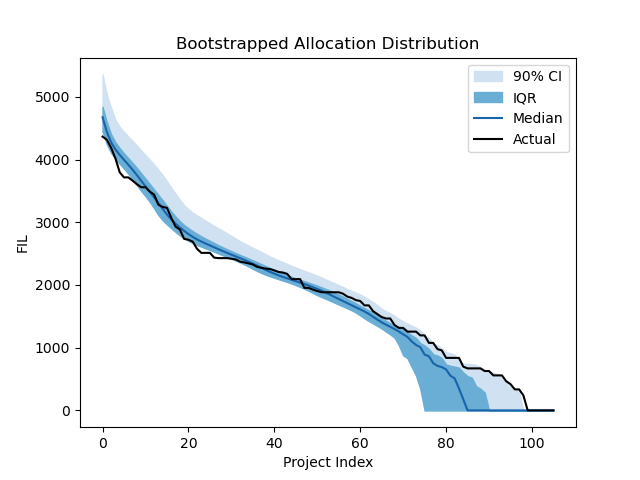

In [119]:
# plt.figure()
num_projects = len(df_nofilter['projectId'].unique())
data_matrix = np.zeros((len(ll), num_projects))
for ii, l in enumerate(ll):
    funding_dist = np.asarray(list(l.values()))
    funding_dist_sorted = np.sort(funding_dist)[::-1]
    # print(len(funding_dist_sorted))
    # data_matrix.append(funding_dist_sorted)
    data_matrix[ii, 0:len(funding_dist_sorted)] = funding_dist_sorted
# data_matrix = np.asarray(data_matrix)

# compute quantiles
quantiles = np.quantile(data_matrix, [0.05, .25, .50, .75, 0.95], axis=0)

blues = mpl.colormaps['Blues']
plt.figure()
plt.fill_between(np.arange(num_projects), quantiles[0], quantiles[4], color=blues(0.2), label='90% CI')
plt.fill_between(np.arange(num_projects), quantiles[0], quantiles[2], color=blues(0.5), label='IQR')
plt.plot(quantiles[1], label='Median', color=blues(0.8))
data=np.sort(np.asarray(list(cfg2distribution['mean_quorum_SP_False'].values())))[::-1]
plt.plot(data, label='Actual', color='k')
# overlay actual distribution

plt.legend()
plt.xlabel('Project Index')
plt.ylabel('FIL')
plt.title('Bootstrapped Allocation Distribution')
plt.savefig(os.path.join(save_folder, 'bootstrap_allocation_distribution.png'))